In [1]:
%gui qt

This notebook is an example of how to analyze the thickness of a layer of tissue.

## Generate mock data
First, we generate a set of mock data simulating a slab of tissue with three layers.

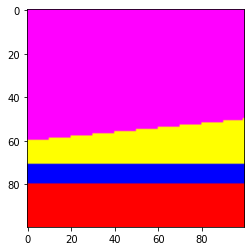

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import draw
from skimage.color import label2rgb

# image size
im_width = 100
im_height = 100

# create the empty image
mock_image_profile = 4 * np.ones((im_height, im_width), dtype=np.uint)

# add layer 1
rr_1, cc_1 = draw.rectangle((80, 0), extent=(20, im_width), shape=mock_image_profile.shape)
mock_image_profile[rr_1, cc_1] = 1

# add layer 2
rr_2, cc_2 = draw.rectangle((70, 0), extent=(10, im_width), shape=mock_image_profile.shape)
mock_image_profile[rr_2, cc_2] = 2

# add layer 3
r_3 = np.array([70, 60, 50, 70])
c_3 = np.array([0, 0, 99, 99])
rr_3, cc_3 = draw.polygon(r_3, c_3)
mock_image_profile[rr_3, cc_3] = 3


plt.imshow(label2rgb(mock_image_profile, bg_label=0));

In [3]:
import napari
mock_image = np.tile(mock_image_profile, (100, 1, 1))

colors = {
    0: [0, 0, 0, 0],
    1: [0.5, 0.79, 0.5, 1],
    2: [0.75, 0.68, 0.83, 1],
    3: [0.99, 0.75, 0.52, 1],
    4: [0, 0, 0, 1]
}
viewer = napari.view_labels(mock_image, color=colors, opacity=0.4)

In [6]:
from morphologyanalysis.volume.label import label_boundaries
edge_labels = label_boundaries(mock_image, background_label=4)

In [71]:
grad_im = np.gradient(mock_image, axis=None)
edge_im = np.sqrt(grad_im[0]**2 + grad_im[1]**2 + grad_im[2]**2)

In [7]:
viewer.add_labels(edge_labels, color=colors);

In [73]:
from scipy.spatial import cKDTree
# find an interface

def find_interface(label_im, interface_label, neighbor_label, neighbor_distance=1):
    # get the coordinates
    label_1_coords = np.argwhere(label_im == interface_label)
    label_2_coords = np.argwhere(label_im == neighbor_label)

    # create the kdtree and find neighboring points
    kdt = cKDTree(label_2_coords)
    d, i = kdt.query(label_1_coords, distance_upper_bound=1.1)

    interface_coords = label_1_coords[d <= neighbor_distance]
    
    return interface_coords
    
# def find_interface(label_im, interface_label, neighbor_label, background_label=0):
label_im = edge_labels
interface_label = 3
neighbor_label = 2

interface_coords = find_interface(label_im=label_im, interface_label=interface_label, neighbor_label=neighbor_label)


# create the interface image
interface_im = np.zeros_like(label_im)
interface_im[interface_coords[:, 0], interface_coords[:, 1], interface_coords[:, 2]] = interface_label
    
viewer.add_labels(interface_im)

<Labels layer 'interface_im' at 0x7fef51a27510>

In [74]:
epi_top_coords = find_interface(label_im=label_im, interface_label=3, neighbor_label=4)

In [60]:
import pyvista as pv

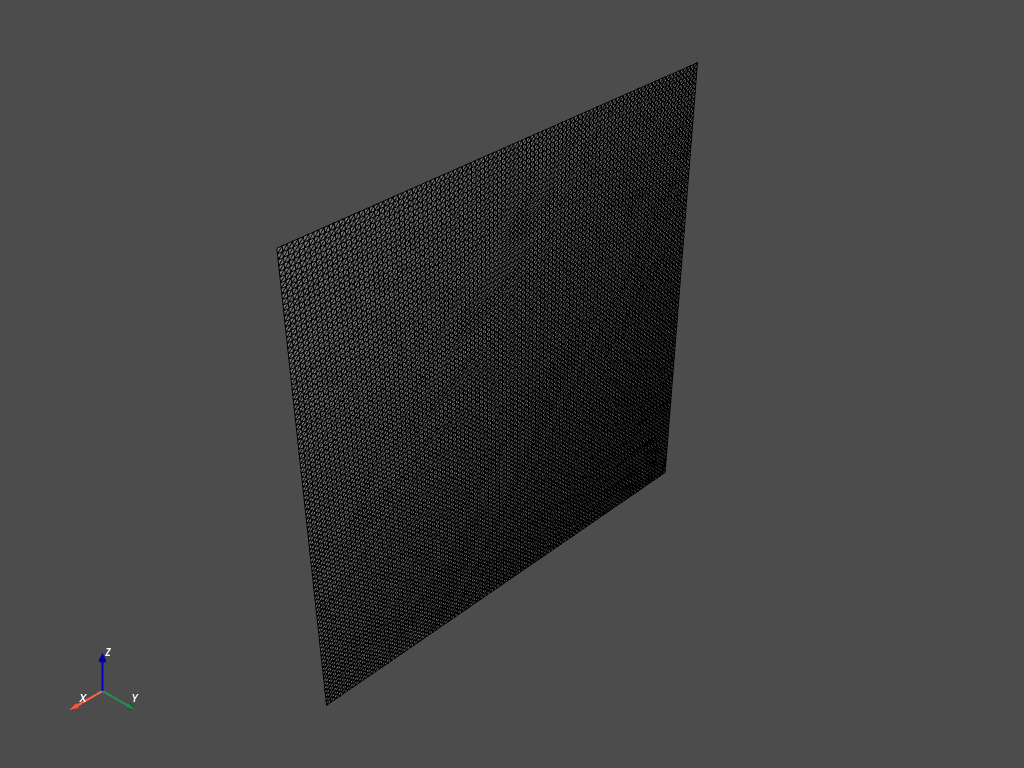

[(205.65767664977298, 226.15767664977298, 205.65767664977298),
 (49.5, 70.0, 49.5),
 (0.0, 0.0, 1.0)]

In [76]:
cloud_bot = pv.PolyData(interface_coords)
surf_bot = cloud_bot.delaunay_2d()
surf_bot.plot(show_edges=True)

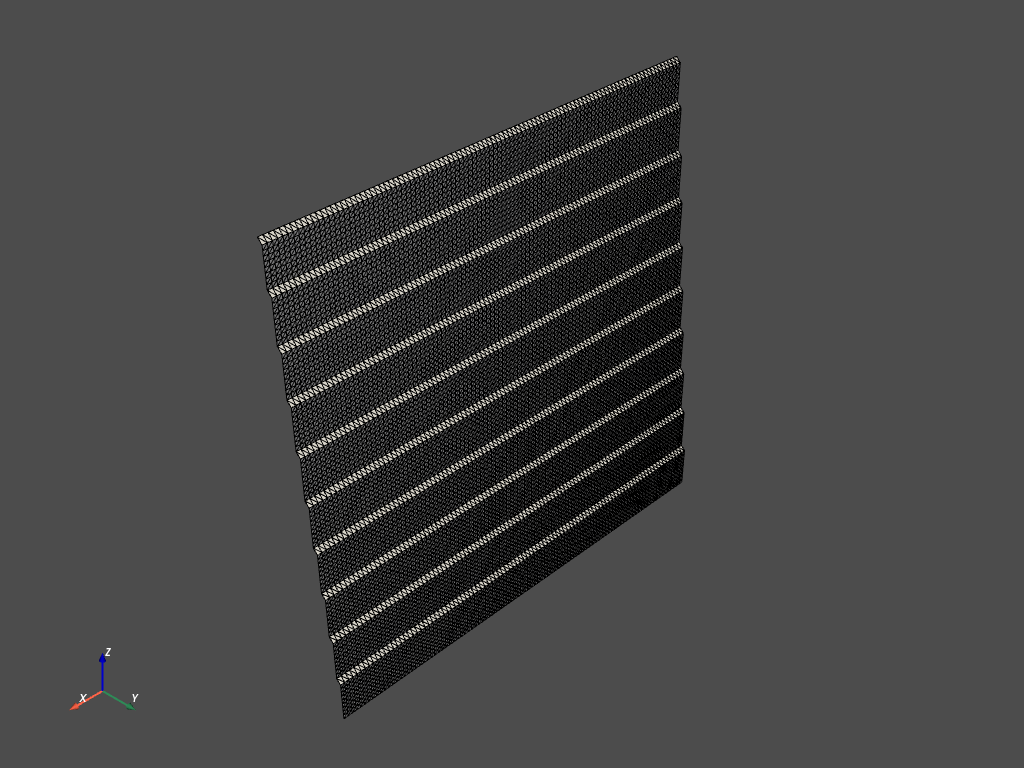

[(206.05549070614128, 211.55549070614128, 206.05549070614128),
 (49.5, 55.0, 49.5),
 (0.0, 0.0, 1.0)]

In [77]:
cloud_top = pv.PolyData(epi_top_coords)
surf_top = cloud_top.delaunay_2d()
surf_top.plot(show_edges=True)

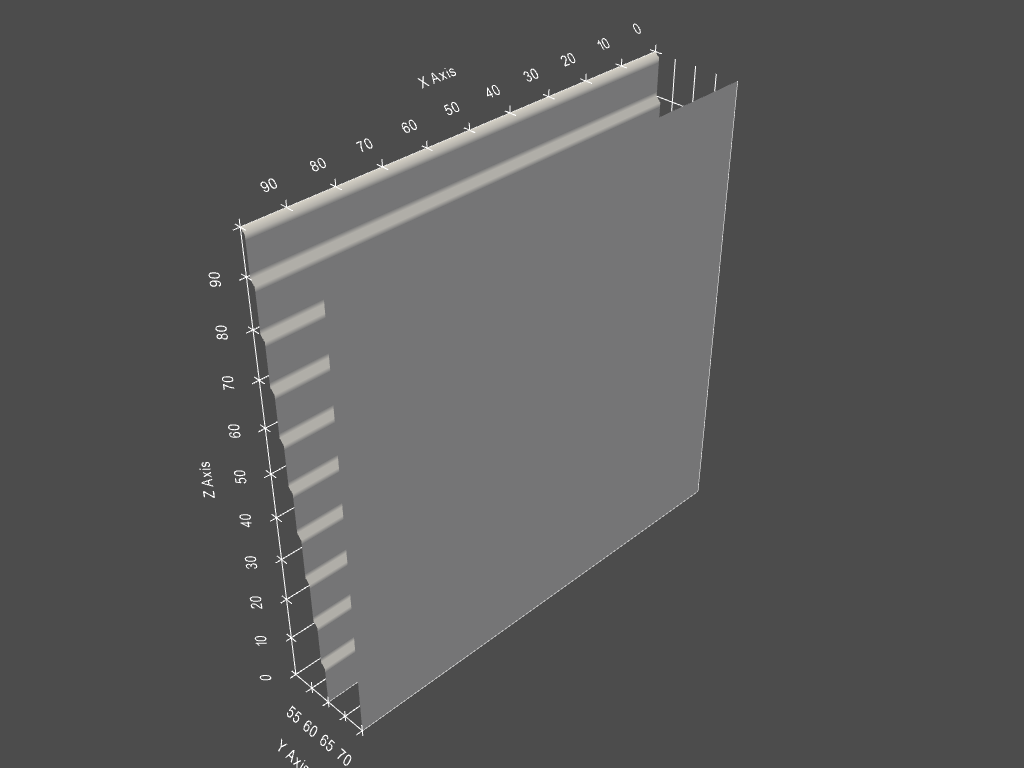

In [79]:
p = pv.Plotter()
p.add_mesh(surf_top, smooth_shading=True)
p.add_mesh(surf_bot, smooth_shading=True)
p.show_grid()
p.show();

In [80]:
surf_bot_n = surf_bot.compute_normals(point_normals=True, cell_normals=False,
                         auto_orient_normals=True)

In [82]:
surf_bot_n["distances"] = np.empty(surf_bot.n_points)
for i in range(surf_bot_n.n_points):
    p = surf_bot_n.points[i]
    vec = surf_bot_n["Normals"][i] * surf_bot_n.length
    p0 = p - vec
    p1 = p + vec
    ip, ic = surf_top.ray_trace(p0, p1, first_point=True)
    dist = np.sqrt(np.sum((ip - p)**2))
    surf_bot_n["distances"][i] = dist

# Replace zeros with nans
mask = surf_bot_n["distances"] == 0
surf_bot_n["distances"][mask] = np.nan
np.nanmean(surf_bot_n["distances"])


14.51

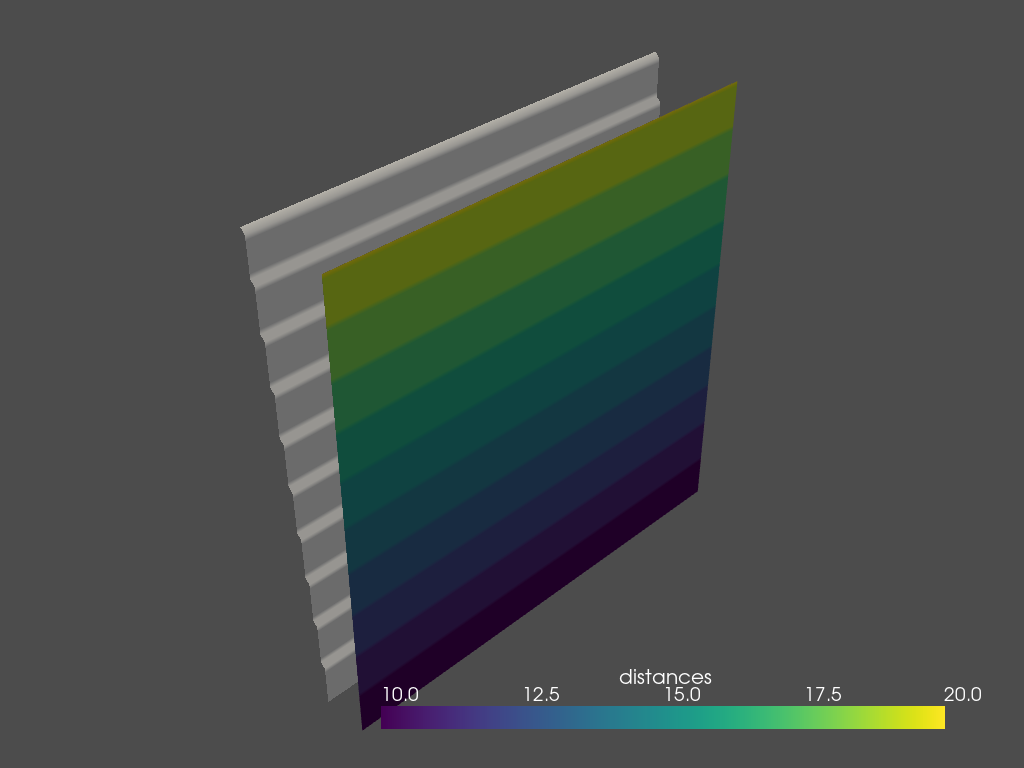

[(207.24291347314963, 217.74291347314963, 207.24291347314963),
 (49.5, 60.0, 49.5),
 (0.0, 0.0, 1.0)]

In [83]:
p = pv.Plotter()
p.add_mesh(surf_bot_n, scalars="distances", smooth_shading=True)
p.add_mesh(surf_top, color=True, opacity=0.75, smooth_shading=True)
p.show()